# Analysis

## Get backend data

In [1]:
import os, re
from main.FolderInfos import FolderInfos
import pandas as pd
import json

FolderInfos.init(test_without_data=True)
list_dataout_folders = os.listdir(FolderInfos.data_folder)
with open(FolderInfos.root_folder+"main"+FolderInfos.separator+"src"+FolderInfos.separator+"analysis"+FolderInfos.separator+"extract_data.json","r") as fp:
    dico_access = json.load(fp)
dico_metrics = {}
available_metrics = dico_access["metrics"].keys()
runs_metadata = []
for f in list_dataout_folders:
    path_json = FolderInfos.data_folder+f+FolderInfos.separator+f+"parameters.json"

    if os.path.exists(path_json) is True:
        with open(path_json,"r") as fp:
            dico = json.load(fp)
        dico_run_metadata = {"folder_id":f}
        for metadata_name,dico_metadata in dico_access["metadata"].items():
            try:
                value_metadata = eval(dico_metadata["access"])(dico)
            except:
                value_metadata = eval(dico_metadata["default"])
            dico_run_metadata[metadata_name] = value_metadata
        runs_metadata.append(dico_run_metadata)

        dico_metrics[f] = {}
        for metric_name,access_func in dico_access["metrics"].items():
            try:
                value_list = eval(access_func)(dico)
            except:
                value_list = {"tr_values":[],"valid_values":[]}
            dico_metrics[f][metric_name] = value_list

df = pd.DataFrame(runs_metadata)
print("Backend data ready !")

C:\Anaconda\envs\pytorch\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


Backend data ready !


## Visualize plots and filter

In [2]:
print(available_metrics)

dict_keys(['accuracy_classification-0.25', 'accuracy_classification-0.1', 'mae', 'loss'])


In [3]:
import ipywidgets as widgets
class PersoToggleButton(widgets.ToggleButton):
    def __init__(self,name=None,*args,**kargs):
        super(PersoToggleButton, self).__init__(*args,**kargs)
        self.name = name

compute_width = lambda value:f"{max(len(str(value)) * 12, 60) + 20}px"
list_vertical_widgets = []
dico_changing_widgets_metadata = {}
list_changing_widgets_metrics = []
list_changing_widgets_tr_valid = []
# Widgets for the metadata ------------------------------------------------------------------
label_metadata_filter = "Metadata"
llocalvertwidgets = []
dico_changing_widgets_reorganized = {"metadata":{},"metrics":{},"mode":{}}
for metadata_name in df.columns:

    if metadata_name == "folder_id":
        continue
    possible_values = df[metadata_name].unique()
    label = widgets.Label(metadata_name)
    dico_changing_widgets_reorganized["metadata"][metadata_name] = {str(value):PersoToggleButton(
        value=True,
        description=str(value),
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='',
        icon='check',
        layout = widgets.Layout(width = compute_width(value), margin='0px 0px 0px 0px'),
        name="metadata|"+metadata_name
    ) for value in possible_values}

    possibilities = list(dico_changing_widgets_reorganized["metadata"][metadata_name].values())
    dico_changing_widgets_metadata[metadata_name] = possibilities
    box = widgets.HBox(layout=widgets.Layout(width='100%',display='inline-flex',flex_flow='row wrap'),width='100%')
    box.overflow_x = 'auto'
    box.children = [label]+possibilities
    llocalvertwidgets.append(box)

box = widgets.VBox(width='100%')
box.children = llocalvertwidgets
list_vertical_widgets.append(box)
# Widgets to select metrics ---------------------------------------------------------------
label_metrics_filter = "Metrics"
dico_changing_widgets_reorganized["metrics"] = {str(metric_name):PersoToggleButton(
        value=True,
        description=metric_name,
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='',
        icon='check',
        layout = widgets.Layout(width = compute_width(metric_name), margin='0px 0px 0px 0px'),
        name="metrics"
    )
    for metric_name in available_metrics}
possibilities = list(dico_changing_widgets_reorganized["metrics"].values())
list_changing_widgets_metrics = possibilities
box = widgets.HBox(layout=widgets.Layout(width='100%',display='inline-flex',flex_flow='row wrap'),width='100%')
box.overflow_x = 'auto'
box.children = possibilities
list_vertical_widgets.append(box)

# widgets to select tr or valid ----------------------------------------------------------
label_tr_valid_filter = "Mode_of_training"
possibilities = [PersoToggleButton(
        value=True,
        description=mode,
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='',
        icon='check',
        layout = widgets.Layout(width = compute_width(mode), margin='0px 0px 0px 0px'),
        name="mode"
    )
    for mode in ["tr","valid"]]
list_changing_widgets_tr_valid = possibilities
box = widgets.HBox(layout=widgets.Layout(width='100%',display='inline-flex',flex_flow='row wrap'),width='100%')
box.overflow_x = 'auto'
box.children = possibilities
list_vertical_widgets.append(box)

titles = ["Metadata", "Metrics","Mode_of_training"]
l = []
for item,title in zip(list_vertical_widgets,titles):
    accordion = widgets.Accordion(children=[item],titles=(title,))
    accordion.set_title(0,title)
    accordion.selected_index = 0
    l.append(accordion)
# widget for moving average
moving_average = widgets.IntText(
    value=100,
    description='mean_window',
    disabled=False
)
# widget to toggle log scale for the y axis
y_log_scale = widgets.ToggleButton(
        value=True,
        description="logy",
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='',
        icon='check',
        layout = widgets.Layout(width = compute_width("logy"), margin='0px 0px 0px 0px')
    )

global_box = widgets.VBox(l+[moving_average,y_log_scale])

# Handlers --------------------------------------------------------------------------------------
from IPython.display import display,clear_output
import plotly.graph_objects as go
import main.src.analysis.tools as tls
def filter_metadata():
    global states
    global query
    # Extract informations from widgets to build a query for the dataframe
    list_sub_requests_1 = []
    for metadata_name,dico_metadata in states["metadata"].items():
        list_sub_requests_2 = []
        for name,state in dico_metadata.items():
            if state is True:
                type_data = type(df[metadata_name][0])
                if type_data is str:
                    name = f"\"{name}\""
                list_sub_requests_2.append(f"({metadata_name} == {name})")
        if len(list_sub_requests_2) > 0:
            poss = r" or ".join(list_sub_requests_2)
            list_sub_requests_1.append(f"({poss})")
    filtered_dataframe = df
    if len(list_sub_requests_1) > 0:
        query = r" or ".join(list_sub_requests_1)
        print(query)
        # Apply the query to the dataframe
        filtered_dataframe = df.query(query)
    list_runs = filtered_dataframe["folder_id"].unique()
    return list_runs,filtered_dataframe
def filter_metrics(runs):
    global states
    new_dico = {}
    for f,dico in dico_metrics.items():
        if f not in runs:
            continue
        new_dico[f] = {}
        for metric_name,list_values in dico.items():
            if states["metrics"][metric_name] is True:
                new_dico[f][metric_name] = list_values
    return new_dico
def actualize_available_possibilities(dico_vals,filtered_dataframe):
    global states, dico_changing_widgets_metadata
    for column in filtered_dataframe.columns[1:]:
        values_available = filtered_dataframe[column].unique()
        for value in df[column].unique():
            w = dico_changing_widgets_reorganized["metadata"][column][str(value)]
            if value not in values_available:
                w.disabled = True
            else:
                w.disabled = False
def plot(dico_vals,filtered_dataframe):
    global states
    import numpy as np
    list_scatters = []
    import matplotlib.pyplot as plt
    plt.clf()
    for run,dico_metrics in dico_vals.items():
        line_dataframe = filtered_dataframe[filtered_dataframe["folder_id"] == run]
        batch_size_tr = line_dataframe["tr_batch_size"].values[0]
        batch_size_valid = line_dataframe["valid_batch_size"].values[0]
        for metric_name,metric_values in dico_metrics.items():
            if metric_name == "loss":
                metric_name = "loss_"+filtered_dataframe[filtered_dataframe["folder_id"] == run]["loss"].values[0]
                access_name = "_loss"
            else:
                access_name = "_values"
            global states
            for mode,state in states["mode"].items():
                if state is False:
                    continue
                batch_size = batch_size_tr if mode == "tr" else batch_size_valid
                window = int(moving_average.value/batch_size)
                if "loss" in metric_name:
                    access_name1 = "attr_"+mode+access_name
                else:
                    access_name1 = mode + access_name
                v = np.array(tls.moving_mean(np.array(metric_values[access_name1]),window=window))
                x = np.arange(0,v.shape[0]) * batch_size
                x = pd.Series(x)
                v = pd.Series(v)
                graph = go.Scatter(x=x,y=v,mode='lines',name=f"{metric_name} {mode} {run}",
                                   hovertemplate='Sample n°: %{x}'+f'<br>{metric_name} {mode}<br>{run}:'+' %{y}')
                list_scatters.append(graph)
    fig = go.Figure(
        data=list_scatters,
        layout=go.Layout(
            title=go.layout.Title(text=""),
            xaxis_title="Number of samples processed",
            yaxis_title="Values",
            legend=dict(
                orientation="h",
                y=1,
                x=1
            ),
            yaxis={'tickformat':'.1e',},
            width=900,
            height = 500
        ),
    )
    if states["others"]["logy"] is True:
        fig.update_yaxes(type="log")
    clear_output()
    display(global_box)
    fig.show()
states = {"others":{"mean_window":moving_average.value,"logy":False},
          "mode":{"tr":False,"valid":False},
          "metrics":{k:False for k in available_metrics},
          "metadata":{k:{
              str(k1):False for k1 in df[k].unique()
          } for k in df.columns}
          }
def handler(v):
    print(v)
    global query
    if v["name"] == "disabled":
        return
    global states
    try:
        name = "others"
        try:
            name = v["owner"].name
        except:
            pass
        name = name.split("|")
        print(name)
        try:
            new_val = not(v["new"]["value"])
        except:
            new_val = not(v["new"])
    except Exception as e:
        print(e)
        print(v)
        return
    print(v,name)
    if len(name) == 2:
        states[name[0]][name[1]][v["owner"].description] = not(states[name[0]][name[1]][v["owner"].description])
    else:
        states[name[0]][v["owner"].description] = not(states[name[0]][v["owner"].description])
    runs,filtered_dataframe = filter_metadata()
    dico_vals = filter_metrics(runs)
    plot(dico_vals,filtered_dataframe)
    actualize_available_possibilities(dico_vals,filtered_dataframe)
    print(states["mode"])

for name,liste_w in dico_changing_widgets_metadata.items():
    for w in liste_w:
        w.observe(handler)
for w in list_changing_widgets_metrics:
    w.observe(handler)
list_changing_widgets_metrics[-1].value = True
for w in list_changing_widgets_tr_valid:
    w.observe(handler)
for w in [moving_average,y_log_scale]:
    w.observe(handler)
global_box

{'tr': True, 'valid': True}


<Figure size 432x288 with 0 Axes>

In [4]:
from ipywidgets import Dropdown

choice_folder = Dropdown(
    options=df["folder_id"].unique(),
    value=df["folder_id"].unique()[0],
    description='Folder to vizualize result',
    disabled=False,
         )
display(choice_folder)



Dropdown(description='Folder to vizualize result', options=('2021-06-19_01h51min22s_', '2021-06-19_04h32min09s…

not already computed, processing...


Output()

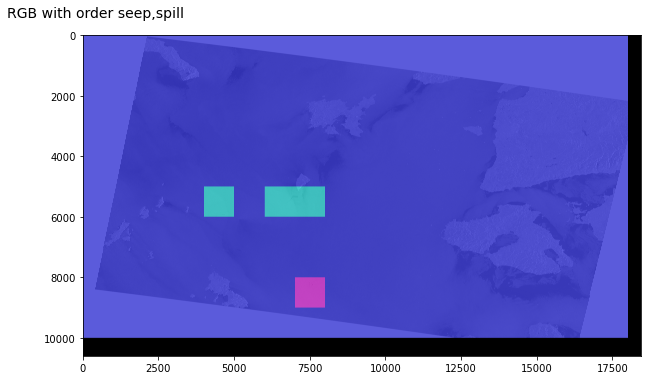

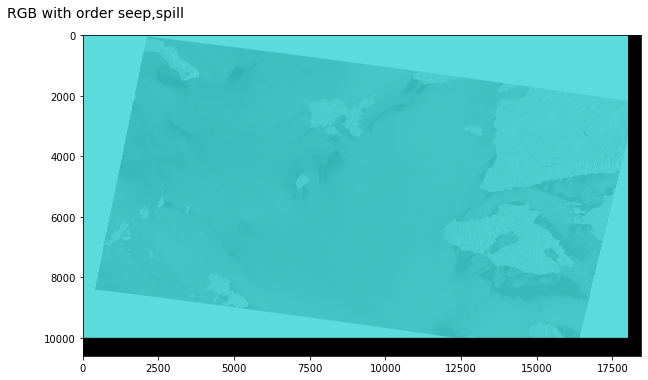

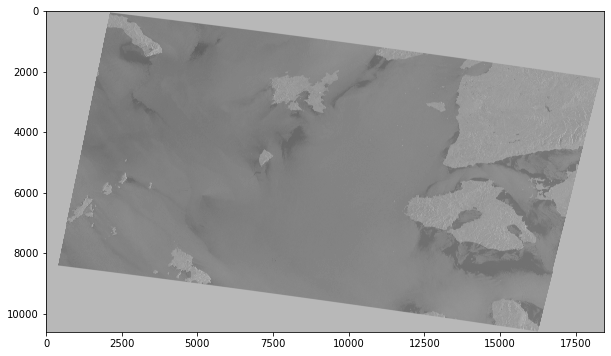

In [5]:
choice_folder1 = choice_folder.value
from main.src.models.ModelFactory import ModelFactory
from main.src.analysis.tools import RGB_Overlay_Patch
import json
name = "027481_0319CB_0EB7"
FolderInfos.init(test_without_data=True)
folder = FolderInfos.data_folder + choice_folder1 + FolderInfos.separator


if os.path.exists(folder+choice_folder1+"_"+name+"_rgb_overlay_pred.png") is True:
    print("loading from cache")
    import matplotlib.pyplot as plt
    from PIL import Image
    image_true = Image.open(folder+choice_folder1+"_"+name+"_rgb_overlay_true.png")
    image_pred = Image.open(folder+choice_folder1+"_"+name+"_rgb_overlay_pred.png")
    plt.figure(figsize=(10,10))
    plt.imshow(image_true)
    plt.figure(figsize=(10,10))
    plt.imshow(image_pred)
else:
    print("not already computed, processing...")
    with open(folder + choice_folder1 + "parameters.json", "r") as fp:
        dico = json.load(fp)

    rgb_overlay = RGB_Overlay_Patch(dataset_name="classificationpatch1",usage_type="classification", patch_creator="fixed_px",
                                grid_size=dico["data"]["attr_patch_creator"]["attr_grid_size_px"],
                                input_size=dico["data"]["attr_dataset"]["attr_resizer"][
                                    "attr_out_size_w"],
                                    classes_to_use=dico["data"]["attr_dataset"]["attr_classes_to_use"]
                                    )
    epoch = 0
    iteration = 60835
    import torch

    device = torch.device("cuda")
    model = ModelFactory(model_name=dico["model"]["attr_model_name"], num_classes=dico["model"]["attr_num_classes"])()
    model.to(device)
    model.load_state_dict(torch.load(f"{folder}{choice_folder1}_model_epoch-{epoch}_it-{iteration}.pt"))
    array_overlay = rgb_overlay(name_img=name, model=model, blending_factor=0.5, device=device)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    plt.imshow(array_overlay[0])
    plt.gcf().text(0.02, 0.75, f"RGB with order {dico['data']['attr_dataset']['attr_classes_to_use']}", fontsize=14)
    plt.savefig(f"{folder}{choice_folder1}_{name}_rgb_overlay_true.png")
    plt.figure(figsize=(10,10))
    plt.imshow(array_overlay[1])
    plt.gcf().text(0.02, 0.75, f"RGB with order {dico['data']['attr_dataset']['attr_classes_to_use']}", fontsize=14)
    plt.savefig(f"{folder}{choice_folder1}_{name}_rgb_overlay_pred.png")
    plt.figure(figsize=(10,10))
    plt.imshow(array_overlay[2],cmap="gray")

In [63]:
from main.src.data.DatasetFactory import DatasetFactory

FolderInfos.init(test_without_data=False)
dataset = DatasetFactory(usage_type="classification", patch_creator="fixed_px",grid_size=1000 , input_size=256)
with open(FolderInfos.input_data_folder+"class_mappings.json","r") as fp:
    dico_corresp = json.load(fp)
plt.figure()
array = dataset.attr_dataset.images[name]
plt.imshow(array,cmap="gray")

plt.figure()
plt.imshow(array[:10,:10],cmap="gray")
import numpy as np
print(np.std(array),np.min(array),np.max(array))